In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.filters import threshold_otsu
import seaborn as sns
from skimage.color import rgb2gray
from skimage.morphology import convex_hull_image
from scipy.spatial import ConvexHull
from skimage.measure import label, regionprops
from skimage.draw import polygon,rectangle,polygon_perimeter

In [2]:
path=r"D:\paper\waterLevel\data_1\0.jpg"
cropped_path = r"D:\paper\waterLevel\arbitrary\x.jpg"

43
0.18547928967614957


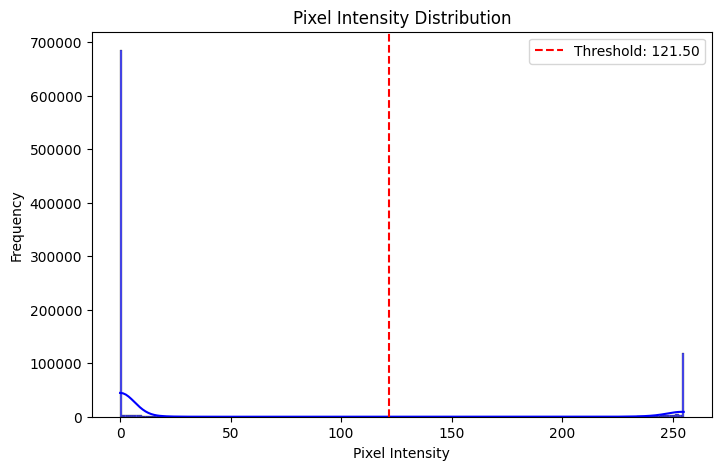

np.float64(0.18547928967614957)

In [29]:
def Feature_1(image_path):
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert("L")
    image_array = np.array(image)
    
    # Calculate threshold using Otsu's method
    dynamic_threshold = threshold_otsu(image_array)
    print(dynamic_threshold)
    
    # Cap the threshold at a minimum of 200
    threshold = np.mean([dynamic_threshold, 200])

    # Compute the histogram of pixel intensities
    unique, counts = np.unique(image_array, return_counts=True)
    intensity_counts = dict(zip(unique, counts))

    # Identify values where the frequency is greater than 1
    valid_values = {val for val, freq in intensity_counts.items() if freq > 1}

    # Count pixels that are both above the threshold and meet the frequency condition
    high_intensity_count = np.sum([pixel in valid_values and pixel >= threshold for pixel in image_array.flatten()])
    
    # Normalize the count
    normalized_count = high_intensity_count / image_array.size
    print(normalized_count)
    
    # Plot histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(image_array.flatten(), bins=256, kde=True, color='blue', alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    return normalized_count
Feature_1(path)

In [3]:
#Frobius Norm on entire Image

def Feature_2(image_path):
    # Load the image and convert it to grayscale
    image = Image.open(image_path).convert("L")
    
    # Convert the image to a numpy array
    image_array = np.array(image)
    
    # Compute the Frobenius norm
    frobenius_norm_value = np.linalg.norm(image_array, 'fro')
    
    return float(f"{frobenius_norm_value:.4f}")

Feature_2(path)

102974.226

In [4]:
def draw_line(r1, c1, r2, c2):
    """
    Generate pixel coordinates for a straight line between two points.
    """
    from skimage.draw import line
    return line(int(r1), int(c1), int(r2), int(c2))

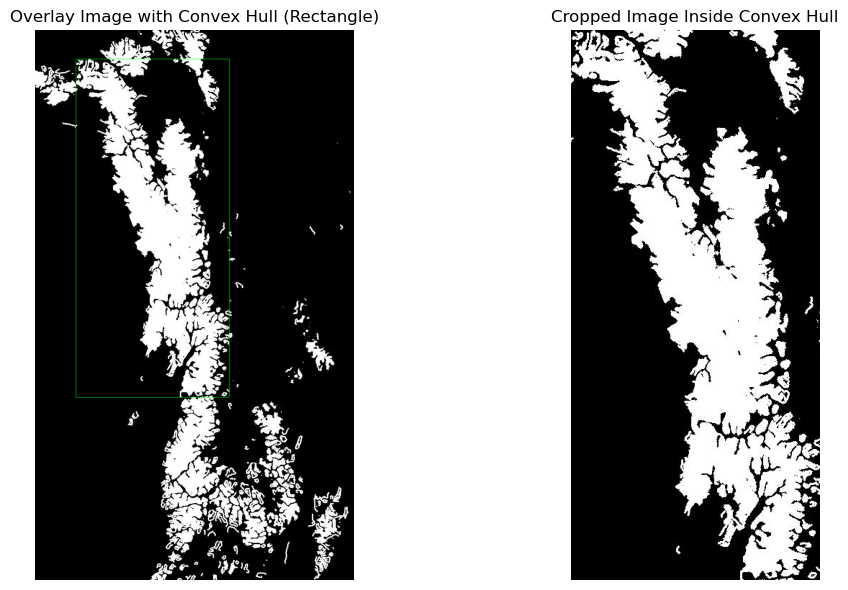

In [6]:

def crop(image_path):
    """
    Applies convex hull processing to the input image, crops the region inside the convex hull,
    shows the overlay image and cropped image side by side in subplots, and returns the cropped image.
    
    Parameters:
        image_path (str): Path to the image file.
        
    Returns:
        np.ndarray: Cropped image inside the convex hull.
    """
    # Load the image
    image = np.array(Image.open(image_path))
    if image.ndim == 3:  # If it's an RGB image
        gray_image = rgb2gray(image)  # Convert to grayscale
    else:
        gray_image = image  # If already grayscale
    
    # Binarize the image using Otsu's threshold
    threshold = threshold_otsu(gray_image)
    binary_image = gray_image >= threshold  # Convert to binary (foreground/background)
    
    # Label connected components (foreground objects)
    labeled_image, num_labels = label(binary_image, connectivity=2, return_num=True)
    
    # Calculate properties of the labeled regions (connected components)
    regions = regionprops(labeled_image)
    
    # Find the region with the largest area (most significant region)
    largest_region = max(regions, key=lambda r: r.area)
    
    # Get the coordinates of the largest region
    largest_region_coords = largest_region.coords
    
    # Compute the convex hull of the largest region's coordinates
    hull = ConvexHull(largest_region_coords)
    
    # Get the vertices of the convex hull
    hull_points = largest_region_coords[hull.vertices]
    
    # Create a mask from the convex hull
    mask = np.zeros_like(binary_image, dtype=bool)
    rr, cc = polygon(hull_points[:, 0], hull_points[:, 1], mask.shape)
    mask[rr, cc] = True
    
     # Create a bounding box (4-cornered box) around the convex hull
    min_row, min_col = hull_points.min(axis=0)
    max_row, max_col = hull_points.max(axis=0)
    box_corners = np.array([[min_row, min_col],
                            [min_row, max_col],
                            [max_row, max_col],
                            [max_row, min_col]])
    
    # Overlay the green box on the original image
    overlay_image = image.copy()
    if image.ndim == 2:  # Convert grayscale to RGB for visualization
        overlay_image = np.stack([overlay_image] * 3, axis=-1)
    
    # Draw the box
    for i in range(len(box_corners)):
        start = box_corners[i]
        end = box_corners[(i + 1) % len(box_corners)]  # Next corner (wrap around)
        rr, cc = draw_line(start[0], start[1], end[0], end[1])
        overlay_image[rr, cc] = [0, 255, 0]  # Green color for the box
    # Overlay the green box on the original image
    overlay_image = image.copy()
    if image.ndim == 2:  # Convert grayscale to RGB for visualization
        overlay_image = np.stack([overlay_image] * 3, axis=-1)
    
    # Draw the box
    for i in range(len(box_corners)):
        start = box_corners[i]
        end = box_corners[(i + 1) % len(box_corners)]  # Next corner (wrap around)
        rr, cc = draw_line(start[0], start[1], end[0], end[1])
        overlay_image[rr, cc] = [0, 255, 0]  # Green color for the box
    
    # Use the mask to extract the region inside the convex hull
    cropped_image = image[int(min_row):int(max_row), int(min_col):int(max_col)]
    
    # Create subplot with 2 images side by side
    plt.figure(figsize=(12, 6))  # Adjusted figure size for better clarity
    
    # Plot the overlay image with convex hull rectangle
    plt.subplot(1, 2, 1)  # (rows, cols, position)
    plt.imshow(overlay_image)
    plt.title('Overlay Image with Convex Hull (Rectangle)')
    plt.axis('off')
    
    # Plot the cropped image
    plt.subplot(1, 2, 2)  # (rows, cols, position)
    plt.imshow(cropped_image)
    plt.title('Cropped Image Inside Convex Hull')
    plt.axis('off')
    
    # Show the subplots
    plt.tight_layout()
    plt.show()
    
    # Save the cropped image as a new file
    cropped_image_pil = Image.fromarray(cropped_image)
    cropped_image_pil.save(cropped_path)
    
    # Return the cropped image
    return cropped_image


crop=crop(path)